In [1]:
import torch
import torch.nn as nn
import os 
import numpy as np
import torch.optim as optim
import time

# from torchvision import datasets, transforms

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Lb vectors from:  ../../../../data/spotify_dataset_sin_duplicados_4.csv


In [3]:
class MLP(nn.Module):
    def __init__(self, capas):
        super(MLP, self).__init__()
        layers = []
        # Capas 
        for i in range(len(capas)-2):
            layers.append(nn.Linear(capas[i], capas[i+1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(capas[-2], capas[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
        


In [4]:
DATA_PATH ="../../../../data"
path_lb_embb = os.path.join(DATA_PATH, f"embbedings_khipu/tfidf_numeric_B.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

## CONFIGURATIONS

TESTING = False
SCALED = True
_EMBEDDINGS = np.load(path_lb_embb , mmap_mode="r")

if TESTING:
    _NROWS = 9000
    _EMBEDDINGS = _EMBEDDINGS[:_NROWS]
    _EPHOCS = 30
else:
    _NROWS = None
    _EPHOCS = 30

if SCALED:
    scaler = MinMaxScaler(feature_range=(0, 1))
    _EMBEDDINGS = scaler.fit_transform(_EMBEDDINGS)

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

y = df['Explicit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Convertir data a tensores
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # labels como enteros

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# Crear datasets
trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
testDataset  = TensorDataset(X_test_tensor,  y_test_tensor)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle= True)
testLoader  = DataLoader( testDataset, batch_size=64, shuffle=False)

In [5]:
net = MLP([X_train.shape[1],32, 64,32,1])
# Total de parámetros
total_params = sum(p.numel() for p in net.parameters())
print(f"Total parámetros: {total_params}")

# Parámetros entrenables
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params}")

Total parámetros: 164833
Parámetros entrenables: 164833


In [6]:
# Pasar la red a la GPU
net = net.to(device)

# Loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)

In [7]:
start_time = time.time() 

In [8]:
def train_deep_rn(net, trainLoader, testLoader, criterion, optimizer, device, n_epoch=20, target_f1=0.95, print_every=126):
    train_losses = []
    test_losses = []
    best_f1_score = 0.0
    best_pred = None
    best_ephoc = None
    best_labels = None
    AUC_according_best_f1 = 0.0

    for epoch in range(n_epoch):
        # Training
        net.train()
        total_train_loss = 0
        for embbedings, labels in trainLoader:
            embbedings, labels = embbedings.to(device), labels.to(device).float()
            outputs = net(embbedings).squeeze(1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(trainLoader)
        train_losses.append(avg_train_loss)

        # Evaluation
        net.eval()
        total_test_loss = 0
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for embbedings, labels in testLoader:
                embbedings, labels = embbedings.to(device), labels.to(device).float()
                outputs = net(embbedings).squeeze(1)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).int()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        avg_test_loss = total_test_loss / len(testLoader)
        test_losses.append(avg_test_loss)

        # Metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs) 
        if f1 > best_f1_score:
            best_f1_score = f1
            best_pred = all_preds
            best_ephoc = epoch
            best_labels = all_labels.copy()
            AUC_according_best_f1 = auc
            epocas= epoch
        if f1 >= target_f1:
            print(f"Target F1-score {target_f1} alcanzado en la época {epoch}. Deteniendo entrenamiento.")
            break
        if epoch % print_every == 0:
            print(f"Epoch [{epoch}/{n_epoch}] "
                  f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
                  f"F1: {f1:.4f}, AUC: {auc:.4f}")

    print("Mejores resultados en la época: ", best_ephoc)
    print("f1-score", best_f1_score)
    print("AUC según el mejor F1-score", AUC_according_best_f1)
    return train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1



# train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1 = train_deep_rn(net, trainLoader, testLoader, criterion, optimizer, device, n_epoch=_EPHOCS, target_f1=0.95, print_every=2)


In [9]:
def train_vs_eval_loss(train_losses, test_losses):
    epochs = len(train_losses)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# train_vs_eval_loss(train_losses, test_losses)

In [10]:
def evaluar_modelo(y_true, y_pred, params=None, labels=('Not Explicit', 'Explicit'),
                save_dir="resultados"):
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    title = "Confusion Matrix"
    if params is not None:
        title += f" (Epoch = {params})"
    plt.title(title)

    # Guardar o mostrar
    # if save:
    os.makedirs(save_dir, exist_ok=True)
    filename = f"confusion_matrix_param_{params if params is not None else 'final'}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    print(f"Matriz de confusión guardada en: {filepath}")
    plt.close()
    # else:
    # plt.show()

    # Métricas
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
# evaluar_modelo(best_labels, best_pred, 20, labels=('Not Explicit', 'Explicit'), save_dir="resulta3dos")
 

### f1-score VS cantidad de parámetros

In [11]:
nets = {
    # Pequeña y rápida
    "1": [X_train.shape[1], 32, 1],  
    
    # Mediana
    "2": [X_train.shape[1], 64, 32, 1],  
    
    # Más profunda
    "3": [X_train.shape[1], 128, 64, 32, 1],  
    
    # Red grande
    "4": [X_train.shape[1], 256, 128, 64, 32, 1],  
    
    # Variante con capas decrecientes más suaves
    "5": [X_train.shape[1], 512, 256, 128, 64, 1],

    "6": [X_train.shape[1], 1024, 512, 256, 128, 64, 32, 1],
}



Entrenando red 1 con capas [5018, 32, 1]

--- Iteración 1 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.2025, Test Loss: 0.1375, F1: 0.8857, AUC: 0.9828


Epoch [10/30] Train Loss: 0.0795, Test Loss: 0.1301, F1: 0.8991, AUC: 0.9859


Epoch [20/30] Train Loss: 0.0195, Test Loss: 0.1638, F1: 0.9155, AUC: 0.9876


Mejores resultados en la época:  27
f1-score 0.9184104434632367
AUC según el mejor F1-score 0.9882638707385418


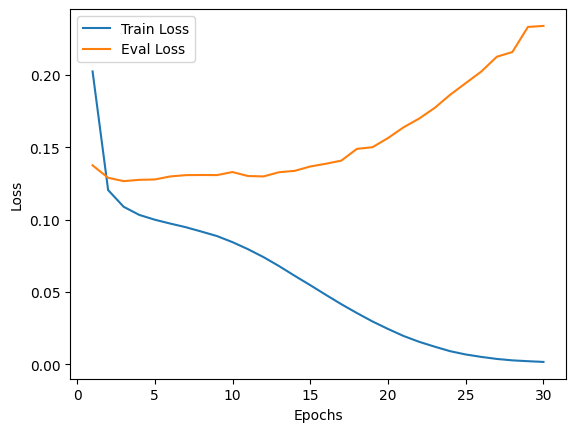

Confusion Matrix:
 [[15994   416]
 [  434  4784]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9607
Precision:  0.9200
Recall:     0.9168
F1-score:   0.9184

--- Iteración 2 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.2034, Test Loss: 0.1377, F1: 0.8835, AUC: 0.9826


Epoch [10/30] Train Loss: 0.0734, Test Loss: 0.1268, F1: 0.9044, AUC: 0.9865


Epoch [20/30] Train Loss: 0.0445, Test Loss: 0.1392, F1: 0.9073, AUC: 0.9865


Mejores resultados en la época:  17
f1-score 0.9110292692382245
AUC según el mejor F1-score 0.9867666276838086


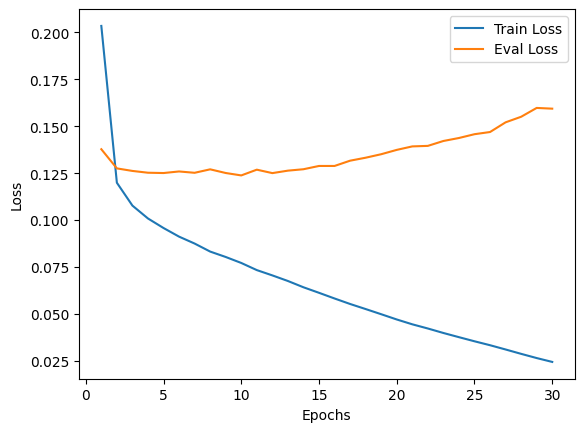

Confusion Matrix:
 [[16010   400]
 [  518  4700]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9576
Precision:  0.9216
Recall:     0.9007
F1-score:   0.9110

--- Iteración 3 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.2008, Test Loss: 0.1369, F1: 0.8860, AUC: 0.9828


Epoch [10/30] Train Loss: 0.0645, Test Loss: 0.1274, F1: 0.9031, AUC: 0.9865


Epoch [20/30] Train Loss: 0.0328, Test Loss: 0.1504, F1: 0.9065, AUC: 0.9862


Mejores resultados en la época:  22
f1-score 0.9066536203522505
AUC según el mejor F1-score 0.9861106517564825


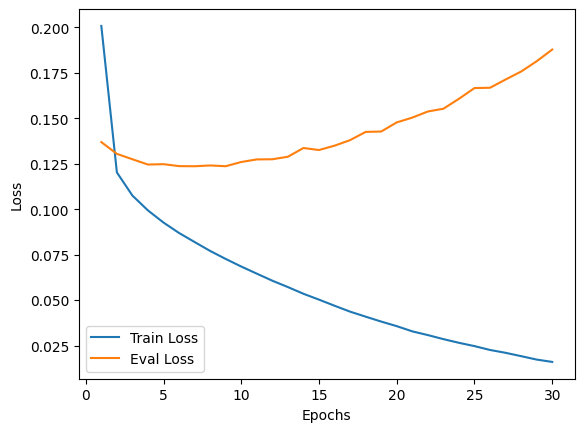

Confusion Matrix:
 [[16041   369]
 [  585  4633]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9559
Precision:  0.9262
Recall:     0.8879
F1-score:   0.9067

--- Iteración 4 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.2067, Test Loss: 0.1387, F1: 0.8838, AUC: 0.9823


Epoch [10/30] Train Loss: 0.0575, Test Loss: 0.1231, F1: 0.9097, AUC: 0.9877


Epoch [20/30] Train Loss: 0.0124, Test Loss: 0.1649, F1: 0.9159, AUC: 0.9880


Mejores resultados en la época:  25
f1-score 0.9177909346792197
AUC según el mejor F1-score 0.9882631291533152


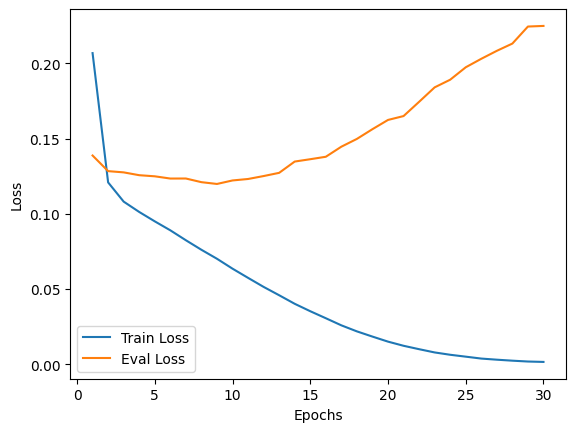

Confusion Matrix:
 [[16053   357]
 [  490  4728]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9608
Precision:  0.9298
Recall:     0.9061
F1-score:   0.9178
Tiempo total para red 1: 393.01 segundos

Entrenando red 2 con capas [5018, 64, 32, 1]

--- Iteración 1 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.1814, Test Loss: 0.1323, F1: 0.8916, AUC: 0.9839


Epoch [10/30] Train Loss: 0.0018, Test Loss: 0.2742, F1: 0.9220, AUC: 0.9883


Epoch [20/30] Train Loss: 0.0001, Test Loss: 0.2964, F1: 0.9265, AUC: 0.9885


Mejores resultados en la época:  20
f1-score 0.9264705882352942
AUC según el mejor F1-score 0.9884870703739854


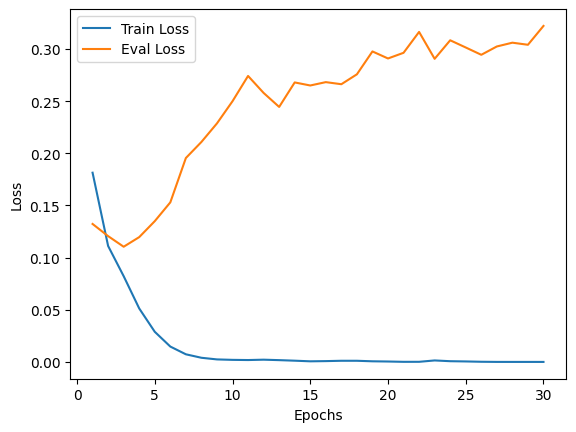

Confusion Matrix:
 [[16080   330]
 [  430  4788]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9649
Precision:  0.9355
Recall:     0.9176
F1-score:   0.9265

--- Iteración 2 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.1783, Test Loss: 0.1326, F1: 0.8900, AUC: 0.9838


Epoch [10/30] Train Loss: 0.0020, Test Loss: 0.2777, F1: 0.9209, AUC: 0.9888


Epoch [20/30] Train Loss: 0.0003, Test Loss: 0.3346, F1: 0.9197, AUC: 0.9894


Mejores resultados en la época:  28
f1-score 0.9257153868388092
AUC según el mejor F1-score 0.9894487487530275


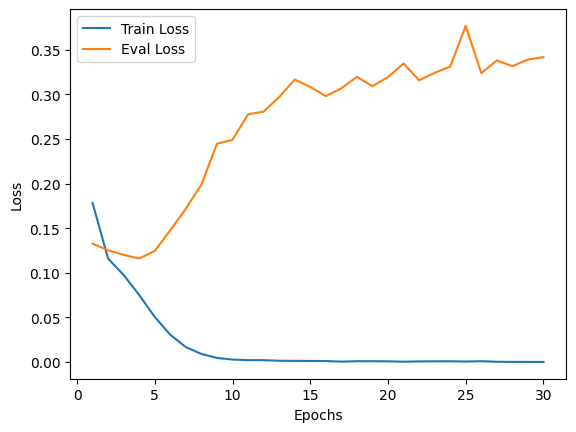

Confusion Matrix:
 [[16053   357]
 [  414  4804]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9644
Precision:  0.9308
Recall:     0.9207
F1-score:   0.9257

--- Iteración 3 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.1767, Test Loss: 0.1316, F1: 0.8899, AUC: 0.9843


Epoch [10/30] Train Loss: 0.0028, Test Loss: 0.2477, F1: 0.9158, AUC: 0.9889


Epoch [20/30] Train Loss: 0.0001, Test Loss: 0.2779, F1: 0.9221, AUC: 0.9896


Mejores resultados en la época:  27
f1-score 0.9254772749297413
AUC según el mejor F1-score 0.9895408863379913


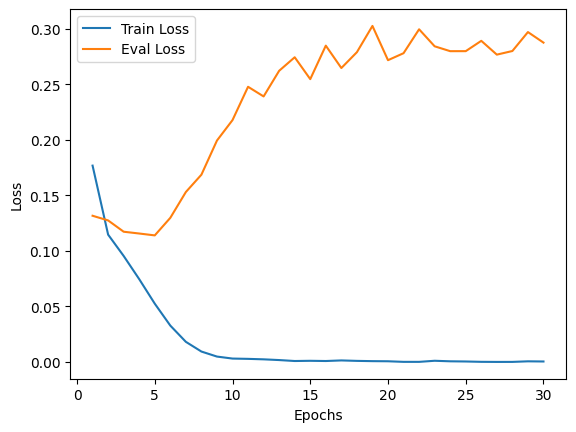

Confusion Matrix:
 [[16084   326]
 [  443  4775]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9644
Precision:  0.9361
Recall:     0.9151
F1-score:   0.9255

--- Iteración 4 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.1857, Test Loss: 0.1348, F1: 0.8873, AUC: 0.9833


Epoch [10/30] Train Loss: 0.0022, Test Loss: 0.2785, F1: 0.9169, AUC: 0.9875


Epoch [20/30] Train Loss: 0.0002, Test Loss: 0.3267, F1: 0.9206, AUC: 0.9877


Mejores resultados en la época:  23
f1-score 0.922512077294686
AUC según el mejor F1-score 0.9873666110068998


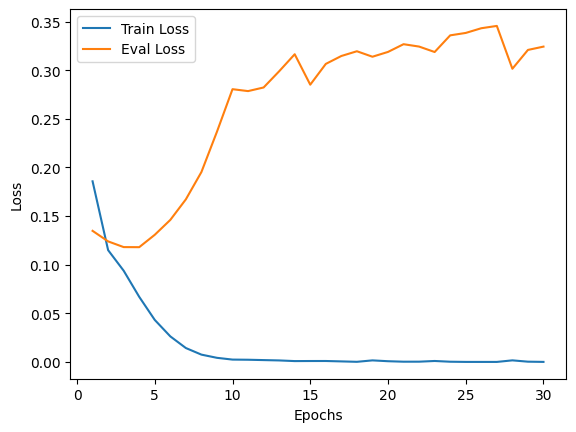

Confusion Matrix:
 [[16052   358]
 [  444  4774]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9629
Precision:  0.9302
Recall:     0.9149
F1-score:   0.9225
Tiempo total para red 2: 424.19 segundos

Entrenando red 3 con capas [5018, 128, 64, 32, 1]

--- Iteración 1 de 4 para la red 3 ---


Epoch [0/30] Train Loss: 0.1788, Test Loss: 0.1318, F1: 0.8936, AUC: 0.9840


Epoch [10/30] Train Loss: 0.0023, Test Loss: 0.2993, F1: 0.9196, AUC: 0.9887


Epoch [20/30] Train Loss: 0.0000, Test Loss: 0.3045, F1: 0.9289, AUC: 0.9898


Mejores resultados en la época:  23
f1-score 0.9289659850760733
AUC según el mejor F1-score 0.9896288021424922


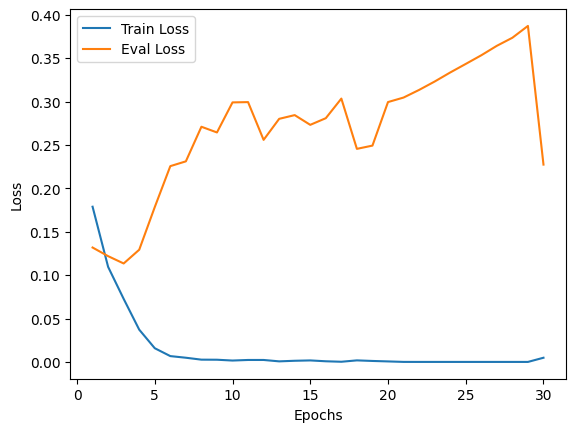

Confusion Matrix:
 [[16102   308]
 [  425  4793]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_652801.png
Accuracy:   0.9661
Precision:  0.9396
Recall:     0.9186
F1-score:   0.9290

--- Iteración 2 de 4 para la red 3 ---


Epoch [0/30] Train Loss: 0.1755, Test Loss: 0.1330, F1: 0.8899, AUC: 0.9837


Epoch [10/30] Train Loss: 0.0020, Test Loss: 0.2984, F1: 0.9218, AUC: 0.9885


Epoch [20/30] Train Loss: 0.0008, Test Loss: 0.2567, F1: 0.9262, AUC: 0.9891


Mejores resultados en la época:  28
f1-score 0.9299151964129058
AUC según el mejor F1-score 0.9897249921695608


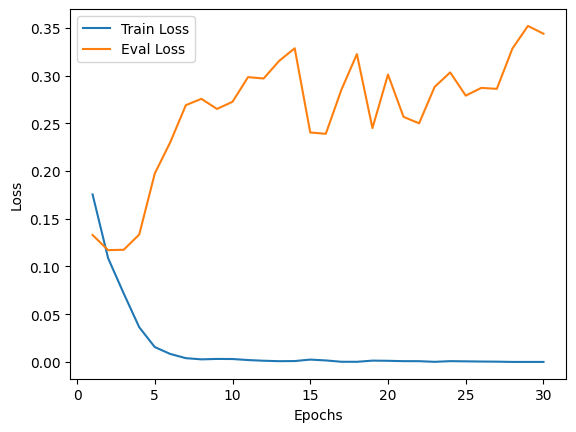

Confusion Matrix:
 [[16139   271]
 [  448  4770]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_652801.png
Accuracy:   0.9668
Precision:  0.9462
Recall:     0.9141
F1-score:   0.9299

--- Iteración 3 de 4 para la red 3 ---


Epoch [0/30] Train Loss: 0.1796, Test Loss: 0.1306, F1: 0.8920, AUC: 0.9843


Epoch [10/30] Train Loss: 0.0020, Test Loss: 0.3220, F1: 0.9219, AUC: 0.9886


Epoch [20/30] Train Loss: 0.0008, Test Loss: 0.2890, F1: 0.9221, AUC: 0.9887


Mejores resultados en la época:  13
f1-score 0.9293593961679891
AUC según el mejor F1-score 0.9890593756342889


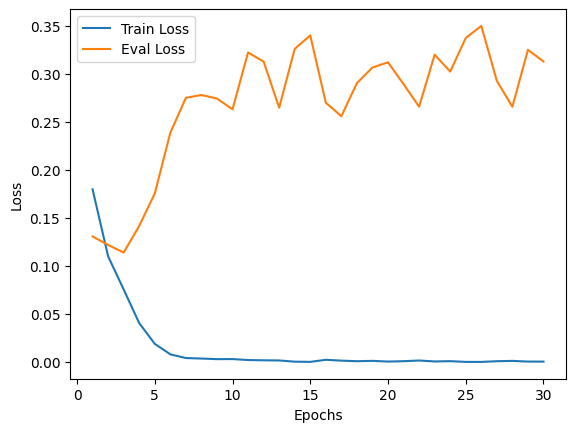

Confusion Matrix:
 [[16096   314]
 [  416  4802]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_652801.png
Accuracy:   0.9662
Precision:  0.9386
Recall:     0.9203
F1-score:   0.9294

--- Iteración 4 de 4 para la red 3 ---


Epoch [0/30] Train Loss: 0.1741, Test Loss: 0.1334, F1: 0.8893, AUC: 0.9837


Epoch [10/30] Train Loss: 0.0015, Test Loss: 0.2788, F1: 0.9250, AUC: 0.9889


Epoch [20/30] Train Loss: 0.0005, Test Loss: 0.2664, F1: 0.9233, AUC: 0.9890


Mejores resultados en la época:  29
f1-score 0.9290197971994205
AUC según el mejor F1-score 0.9894505414039294


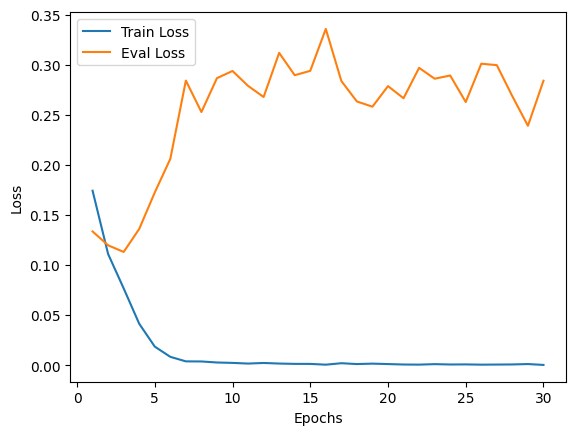

Confusion Matrix:
 [[16083   327]
 [  408  4810]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_652801.png
Accuracy:   0.9660
Precision:  0.9363
Recall:     0.9218
F1-score:   0.9290
Tiempo total para red 3: 455.92 segundos

Entrenando red 4 con capas [5018, 256, 128, 64, 32, 1]

--- Iteración 1 de 4 para la red 4 ---


Epoch [0/30] Train Loss: 0.1709, Test Loss: 0.1277, F1: 0.8928, AUC: 0.9848


Epoch [10/30] Train Loss: 0.0019, Test Loss: 0.1798, F1: 0.9287, AUC: 0.9902


Epoch [20/30] Train Loss: 0.0008, Test Loss: 0.3235, F1: 0.9331, AUC: 0.9903


Mejores resultados en la época:  29
f1-score 0.9353531455036665
AUC según el mejor F1-score 0.9902590444785302


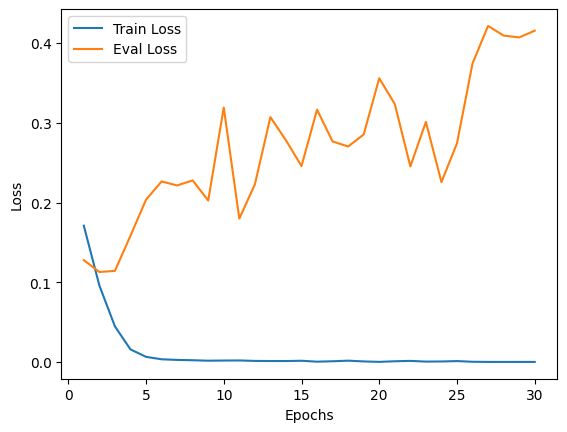

Confusion Matrix:
 [[16111   299]
 [  371  4847]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_1328129.png
Accuracy:   0.9690
Precision:  0.9419
Recall:     0.9289
F1-score:   0.9354

--- Iteración 2 de 4 para la red 4 ---


Epoch [0/30] Train Loss: 0.1739, Test Loss: 0.1283, F1: 0.8946, AUC: 0.9846


Epoch [10/30] Train Loss: 0.0021, Test Loss: 0.2664, F1: 0.9271, AUC: 0.9906


Epoch [20/30] Train Loss: 0.0008, Test Loss: 0.3146, F1: 0.9298, AUC: 0.9899


Mejores resultados en la época:  24
f1-score 0.9314219294846958
AUC según el mejor F1-score 0.9896760358660979


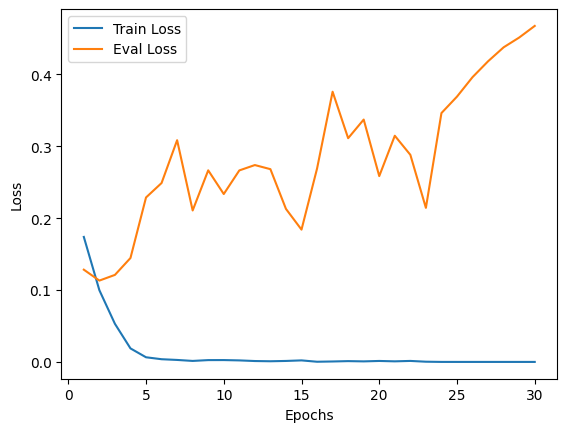

Confusion Matrix:
 [[16112   298]
 [  410  4808]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_1328129.png
Accuracy:   0.9673
Precision:  0.9416
Recall:     0.9214
F1-score:   0.9314

--- Iteración 3 de 4 para la red 4 ---


Epoch [0/30] Train Loss: 0.1729, Test Loss: 0.1381, F1: 0.8881, AUC: 0.9838


Epoch [10/30] Train Loss: 0.0013, Test Loss: 0.2216, F1: 0.9249, AUC: 0.9905


Epoch [20/30] Train Loss: 0.0005, Test Loss: 0.3218, F1: 0.9269, AUC: 0.9893


Mejores resultados en la época:  28
f1-score 0.9314252785247791
AUC según el mejor F1-score 0.9900904535441818


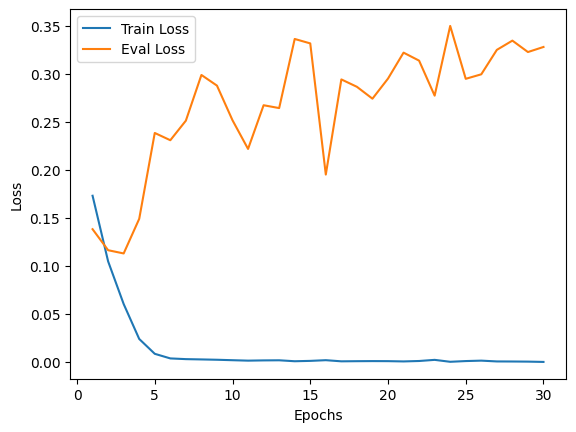

Confusion Matrix:
 [[16065   345]
 [  369  4849]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_1328129.png
Accuracy:   0.9670
Precision:  0.9336
Recall:     0.9293
F1-score:   0.9314

--- Iteración 4 de 4 para la red 4 ---


Epoch [0/30] Train Loss: 0.1697, Test Loss: 0.1288, F1: 0.8909, AUC: 0.9846


Epoch [10/30] Train Loss: 0.0019, Test Loss: 0.1921, F1: 0.9240, AUC: 0.9903


Epoch [20/30] Train Loss: 0.0000, Test Loss: 0.3856, F1: 0.9258, AUC: 0.9905


Mejores resultados en la época:  19
f1-score 0.9318071587932875
AUC según el mejor F1-score 0.9908312563107734


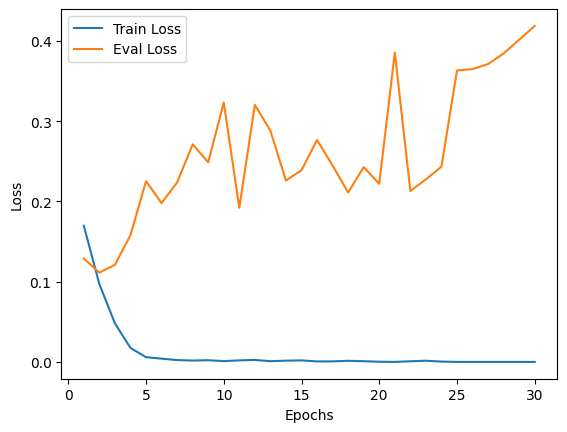

Confusion Matrix:
 [[16122   288]
 [  415  4803]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_1328129.png
Accuracy:   0.9675
Precision:  0.9434
Recall:     0.9205
F1-score:   0.9318
Tiempo total para red 4: 488.99 segundos

Entrenando red 5 con capas [5018, 512, 256, 128, 64, 1]

--- Iteración 1 de 4 para la red 5 ---


Epoch [0/30] Train Loss: 0.1659, Test Loss: 0.1314, F1: 0.8932, AUC: 0.9864


Epoch [10/30] Train Loss: 0.0009, Test Loss: 0.2672, F1: 0.9306, AUC: 0.9910


Epoch [20/30] Train Loss: 0.0010, Test Loss: 0.2588, F1: 0.9290, AUC: 0.9898


Mejores resultados en la época:  27
f1-score 0.9349869198721055
AUC según el mejor F1-score 0.9895475606050308


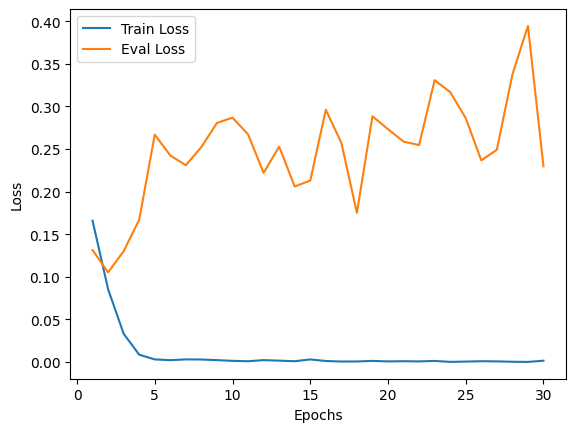

Confusion Matrix:
 [[16132   278]
 [  393  4825]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_2742273.png
Accuracy:   0.9690
Precision:  0.9455
Recall:     0.9247
F1-score:   0.9350

--- Iteración 2 de 4 para la red 5 ---


Epoch [0/30] Train Loss: 0.1656, Test Loss: 0.1261, F1: 0.9020, AUC: 0.9855


Epoch [10/30] Train Loss: 0.0020, Test Loss: 0.2842, F1: 0.9249, AUC: 0.9908


Epoch [20/30] Train Loss: 0.0005, Test Loss: 0.3568, F1: 0.9302, AUC: 0.9905


Mejores resultados en la época:  22
f1-score 0.9341662662181643
AUC según el mejor F1-score 0.990551964803781


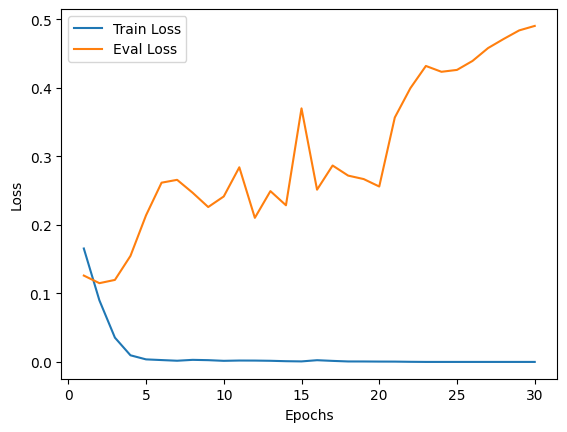

Confusion Matrix:
 [[16083   327]
 [  358  4860]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_2742273.png
Accuracy:   0.9683
Precision:  0.9370
Recall:     0.9314
F1-score:   0.9342

--- Iteración 3 de 4 para la red 5 ---


Epoch [0/30] Train Loss: 0.1672, Test Loss: 0.1263, F1: 0.8984, AUC: 0.9856


Epoch [10/30] Train Loss: 0.0016, Test Loss: 0.2595, F1: 0.9313, AUC: 0.9907


Epoch [20/30] Train Loss: 0.0006, Test Loss: 0.3455, F1: 0.9220, AUC: 0.9890


Mejores resultados en la época:  6
f1-score 0.9343136306471898
AUC según el mejor F1-score 0.9911766481702466


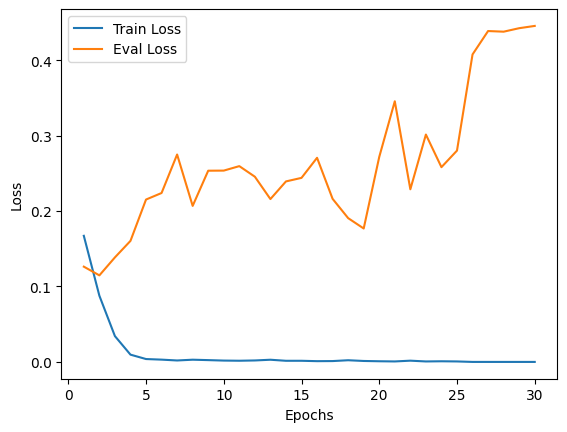

Confusion Matrix:
 [[16120   290]
 [  389  4829]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_2742273.png
Accuracy:   0.9686
Precision:  0.9433
Recall:     0.9255
F1-score:   0.9343

--- Iteración 4 de 4 para la red 5 ---


Epoch [0/30] Train Loss: 0.1675, Test Loss: 0.1282, F1: 0.8939, AUC: 0.9853


Epoch [10/30] Train Loss: 0.0023, Test Loss: 0.2476, F1: 0.9284, AUC: 0.9902


Epoch [20/30] Train Loss: 0.0004, Test Loss: 0.2623, F1: 0.9341, AUC: 0.9907


Mejores resultados en la época:  29
f1-score 0.937324421195389
AUC según el mejor F1-score 0.9901834786957162


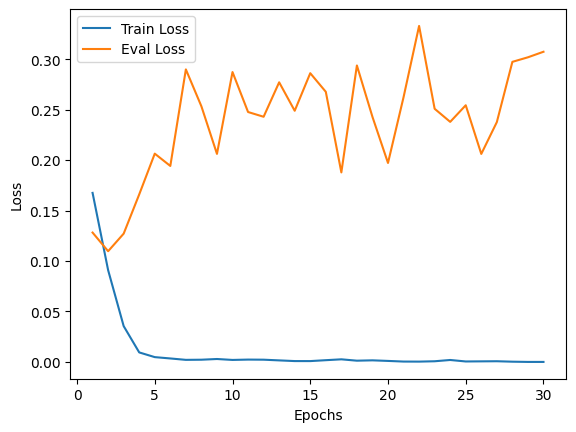

Confusion Matrix:
 [[16143   267]
 [  380  4838]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_2742273.png
Accuracy:   0.9701
Precision:  0.9477
Recall:     0.9272
F1-score:   0.9373
Tiempo total para red 5: 558.63 segundos

Entrenando red 6 con capas [5018, 1024, 512, 256, 128, 64, 32, 1]

--- Iteración 1 de 4 para la red 6 ---


Epoch [0/30] Train Loss: 0.1674, Test Loss: 0.1227, F1: 0.9006, AUC: 0.9860


Epoch [10/30] Train Loss: 0.0024, Test Loss: 0.1881, F1: 0.9313, AUC: 0.9913


Epoch [20/30] Train Loss: 0.0005, Test Loss: 0.3730, F1: 0.9362, AUC: 0.9912


Mejores resultados en la época:  20
f1-score 0.9362399922832063
AUC según el mejor F1-score 0.9911545816303149


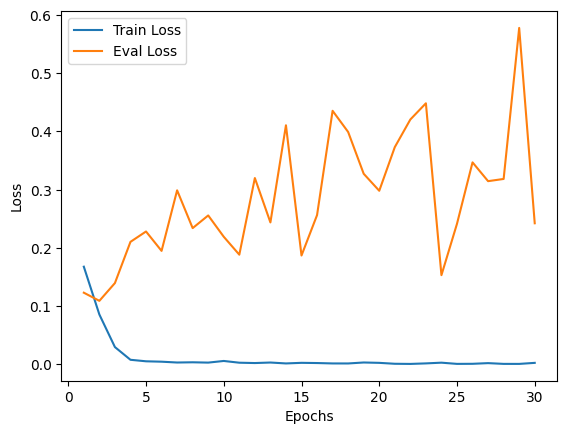

Confusion Matrix:
 [[16114   296]
 [  365  4853]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_5838849.png
Accuracy:   0.9694
Precision:  0.9425
Recall:     0.9300
F1-score:   0.9362

--- Iteración 2 de 4 para la red 6 ---


Epoch [0/30] Train Loss: 0.1685, Test Loss: 0.1288, F1: 0.9013, AUC: 0.9858


Epoch [10/30] Train Loss: 0.0033, Test Loss: 0.2911, F1: 0.9268, AUC: 0.9902


Epoch [20/30] Train Loss: 0.0012, Test Loss: 0.3257, F1: 0.9326, AUC: 0.9898


Mejores resultados en la época:  12
f1-score 0.9342785974324583
AUC según el mejor F1-score 0.9911378229720448


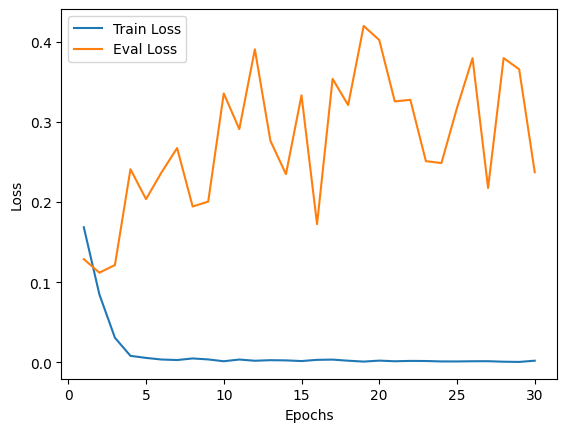

Confusion Matrix:
 [[16066   344]
 [  342  4876]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_5838849.png
Accuracy:   0.9683
Precision:  0.9341
Recall:     0.9345
F1-score:   0.9343

--- Iteración 3 de 4 para la red 6 ---


Epoch [0/30] Train Loss: 0.1670, Test Loss: 0.1271, F1: 0.8963, AUC: 0.9858


Epoch [10/30] Train Loss: 0.0033, Test Loss: 0.3474, F1: 0.9230, AUC: 0.9912


Epoch [20/30] Train Loss: 0.0022, Test Loss: 0.2005, F1: 0.9325, AUC: 0.9912


Mejores resultados en la época:  24
f1-score 0.9359844810863239
AUC según el mejor F1-score 0.9911447074522192


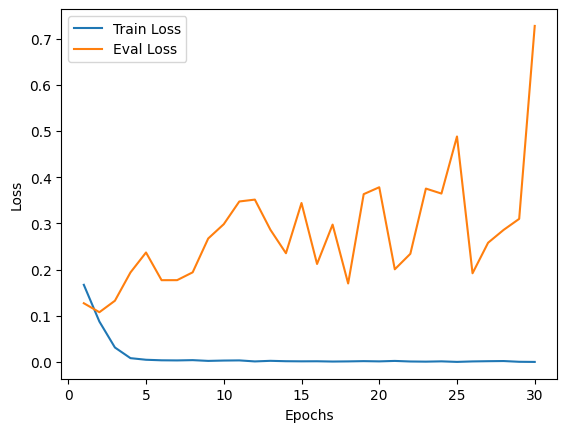

Confusion Matrix:
 [[16143   267]
 [  393  4825]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_5838849.png
Accuracy:   0.9695
Precision:  0.9476
Recall:     0.9247
F1-score:   0.9360

--- Iteración 4 de 4 para la red 6 ---


Epoch [0/30] Train Loss: 0.1658, Test Loss: 0.1246, F1: 0.9010, AUC: 0.9860


Epoch [10/30] Train Loss: 0.0019, Test Loss: 0.2840, F1: 0.9326, AUC: 0.9911


Epoch [20/30] Train Loss: 0.0017, Test Loss: 0.2275, F1: 0.9323, AUC: 0.9908


Mejores resultados en la época:  27
f1-score 0.9364896073903002
AUC según el mejor F1-score 0.9910652352086448


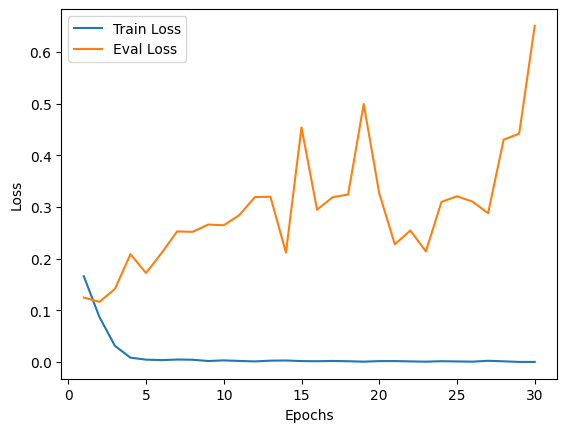

Confusion Matrix:
 [[16102   308]
 [  352  4866]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_5838849.png
Accuracy:   0.9695
Precision:  0.9405
Recall:     0.9325
F1-score:   0.9365
Tiempo total para red 6: 785.11 segundos


In [12]:
veces = 4

n_params = []
f1_scores = []
for name, capas in nets.items():
    print(f"\nEntrenando red {name} con capas {capas}")
    net_ = MLP(capas)

    trainable_params = sum(p.numel() for p in net_.parameters() if p.requires_grad)
    n_params.append(trainable_params)

    
    start_time = time.time()  

    f1_score_result = 0.0
    for i in range(veces):
        print(f"\n--- Iteración {i+1} de {veces} para la red {name} ---")

        net = MLP(capas).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(net.parameters(), lr=0.001)

        train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1 = train_deep_rn(
            net, trainLoader, testLoader, criterion, optimizer, device, 
            n_epoch=_EPHOCS, target_f1=0.95, print_every=10
        )
        f1_score_result+=best_f1_score
        train_vs_eval_loss(train_losses, test_losses)

        evaluar_modelo(best_labels, best_pred, trainable_params, labels=('Not Explicit', 'Explicit'), save_dir=f"resultados")
    f1_scores.append(f1_score_result/veces)
    end_time = time.time() 
    elapsed_time = end_time - start_time
    print(f"Tiempo total para red {name}: {elapsed_time:.2f} segundos")


In [13]:
import numpy as np

np.save("resultados/n_params.npy", np.array(n_params))
np.save("resultados/f1_scores.npy", np.array(f1_scores))


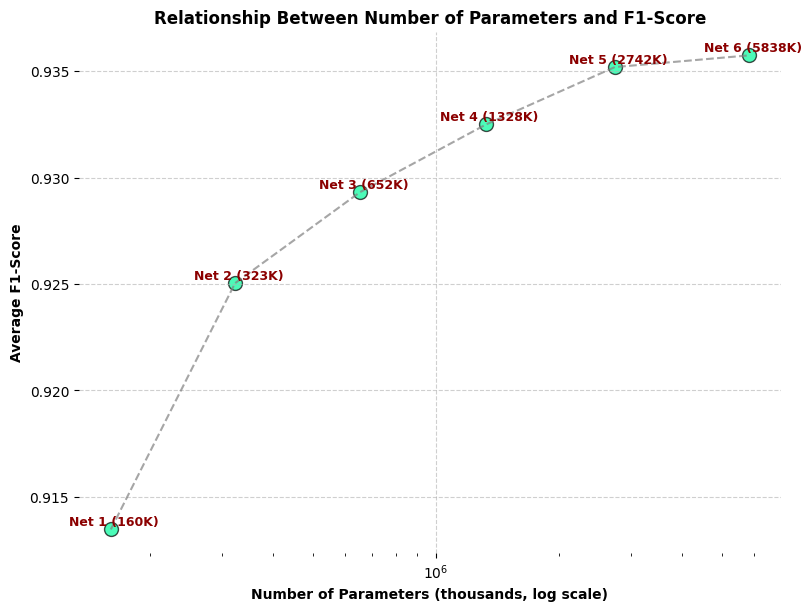

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)

# Tech green color
color_hex = "#00FA9A"  # MediumSpringGreen
ax.scatter(n_params, f1_scores, s=100, color=color_hex, alpha=0.7, edgecolors="k")
ax.plot(n_params, f1_scores, linestyle="--", color="gray", alpha=0.7)

# Labels for each point
for i, (x, y) in enumerate(zip(n_params, f1_scores), start=1):
    params_k = x // 1000
    ax.text(x + x*0.02, y + 0.00005, f"Net {i} ({params_k}K)",
            ha="center", va="bottom", fontsize=9, color="darkred", fontweight="bold")

# Remove plot borders
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Axis labels and title
ax.set_xscale("log")
ax.set_xlabel("Number of Parameters (thousands, log scale)", fontweight="bold")
ax.set_ylabel("Average F1-Score", fontweight="bold")
ax.set_title("Relationship Between Number of Parameters and F1-Score", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.6)
plt.savefig("resultados/params_vs_f1.png", dpi=300, bbox_inches="tight")
plt.show()
